# Imports

In [55]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import time

# Utils

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    """
    Takes the values from the target variable and the predictions
    and draws the graphs for each variable. 
    Saves plots to pdf with `plot_title`.pdf
    Parameters:
        y_test (pd.DataFrame): The validation target values.
        y_pred (pd.DataFrame): The predictions target values.
        plot_title (string, optional): The title of plot.
"""
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig("results/"+plot_title+'.pdf')
    plt.show()


def custom_train_test_split(X, y, test_size=0.2, drop=True, columns_to_drop=[]):
    """
    Splits the dataset into training and testing sets based on unique trajectory IDs.
    Parameters:
        X (pd.DataFrame): The feature dataset containing a 'trajectory_id' column.
        y (pd.DataFrame): The target dataset containing a 'trajectory_id' column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        drop (Boolean): Helper flag to decide weather to drop any columns or not
        columns_to_drop (list, optional): List of columns to drop from the feature dataset. Default is an empty list.
    Returns:
        tuple: A tupple containing the following:
            - X_train (pd.DataFrame): The training set of the feature dataset.
            - X_test (pd.DataFrame): The testing set of the feature dataset.
            - y_train (pd.DataFrame): The training set of the target dataset.
            - y_test (pd.DataFrame): The testing set of the target dataset.
    """
    # Get unique trajectory_ids
    unique_ids = X['trajectory_id'].unique()
    
    # Split the trajectory_ids into train and test sets
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size)

    # Split the data based on the trajectory_ids
    X_train = X[X['trajectory_id'].isin(train_ids)]
    X_test = X[X['trajectory_id'].isin(test_ids)]
    y_train = y[y['trajectory_id'].isin(train_ids)]
    y_test = y[y['trajectory_id'].isin(test_ids)]
    
    if drop:
        X_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop
        Y_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop

        # Drop the specified columns from X and y
        X_train = X_train.drop(columns=X_columns_drop)
        X_test = X_test.drop(columns=X_columns_drop)
        y_train = y_train.drop(columns=Y_columns_drop)
        y_test = y_test.drop(columns=Y_columns_drop)
    
    return X_train, X_test, y_train, y_test

# Rename function - GRID Search sklean
def train_model(pipeline: Pipeline,
                   X_train: pd.DataFrame, 
                   X_val: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_val: pd.DataFrame):
    """
    Evaluates the performance of a machine learning model pipeline on given data.

    This function splits the data into training and testing sets using a custom split function,
    fits the model pipeline on the training data, and then evaluates the model's performance
    on both the training and testing sets. It prints the mean squared error for both sets.

    Parameters:
        pipeline (Pipeline): The machine learning pipeline to be evaluated.
        X (pd.DataFrame): The input features for the model.
        y (pd.DataFrame): The target values for the model.
    Returns:
        y_pred_train: The prediction of the train dataset
        y_pred_val: The prediction of the validation dataset
        model: The model created
    """
    # Creates a model based on the pipeline passed
    model = pipeline.fit(X_train, y_train)
    # Check performance on train
    y_pred_train = model.predict(X_train)

    # Check performance on val
    y_pred_val = model.predict(X_val)
    return y_pred_train, y_pred_val, model

def validate_poly_regression(X_train: pd.DataFrame,
                             y_train: pd.DataFrame,
                             X_val: pd.DataFrame,
                             y_val: pd.DataFrame,
                             regressor=None, 
                             degrees=range(1,15), 
                             max_features=None,
                             verbose=False
                            ):
    
    """
    Validates polynomial regression models of varying degrees and selects the best model based on RMSE.

    Parameters:
    X_train : pd.DataFrame
        Training feature data.
    y_train : pd.DataFrame
        Training target data.
    X_val : pd.DataFrame
        Validation feature data.
    y_val : pd.DataFrame
        Validation target data.
    regressor : estimator object, default=None
        The regressor to use. If None, LinearRegression is used.
    degrees : range, default=range(1, 15)
        Range of polynomial degrees to evaluate.
    max_features : int, default=None
        Maximum number of features to consider (not used in the current implementation).
    plot : bool, default=False
        Whether to plot the results (not used in the current implementation).
    Returns:
    best_model : Pipeline
        The best polynomial regression model.
    best_rmse : float
        The RMSE of the best model.
    best_degree : int
        The degree of the polynomial features for the best model.
    """


    best_rmse = float('inf')
    best_model = None
    best_degree = None
    best_num_features = None

    for degree in degrees:
        model = make_pipeline(StandardScaler() ,PolynomialFeatures(degree=degree), regressor if regressor else LinearRegression())

        # Fit the pipeline on the training data
        if verbose:
            print("Fitting the model")
        model.fit(X_train, y_train)

        # Predict on the training model
        y_pred_train = model.predict(X_train)
        if verbose:
            print("rmse for training: "+str(root_mean_squared_error(y_train, y_pred_train)))

        # Predict on the validation data
        if verbose:
            print("Preddicting the model")
        y_pred = model.predict(X_val)

        # Calculate RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Print the number of features generated by PolynomialFeatures
        num_features = model.named_steps['polynomialfeatures'].n_output_features_
        if verbose:
            print(f"Degree: {degree}, RMSE: {rmse}, Number of features: {num_features}")

        # Update the best model if the current one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_degree = degree
            best_num_features = num_features

    if verbose:
        print(f"Best Degree: {best_degree}, Best RMSE: {best_rmse}")
        
    return best_model, best_rmse, best_degree, best_num_features

def test_regularization(pipeline, X_train, X_val, y_train, y_val, alphas=[0.1, 1.0, 10.0, 100.0], regressor_type='lasso'):
    best_rmse = float('inf')
    best_model = None
    for alpha in alphas:
        if regressor_type == 'lasso':
            pipeline.set_params(regressor=Lasso(alpha=alpha))
        elif regressor_type == 'ridge':
            pipeline.set_params(regressor=Ridge(alpha=alpha))
        else:
            raise ValueError("regressor_type must be either 'lasso' or 'ridge'")
        
        y_pred_train, y_pred_val, model = train_model(pipeline, X_train, X_val, y_train, y_val)
        train_rmse = root_mean_squared_error(y_pred_train, y_train)
        val_rmse = root_mean_squared_error(y_pred_val, y_val)
        print(f"alpha: {alpha}, train: {train_rmse}, validation: {val_rmse}")
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = model
    return best_model, best_rmse



In [57]:
df = pd.read_csv("../data/mlNOVA/mlNOVA/X_train.csv")

# Model Analysis for the Three Body Problem
The problem consists in predicting positions at an instant t given a set of initial positions. <br>
This problem will be aproached as a multivariate regression, and we'll compare the results of using different types of regressions.

In [58]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]
df[df['trajectory_id'] == 157]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,trajectory_id
40349,0.000000,1.000000,0.000000,0.000000,0.000000,-0.006029,0.411829,0.000000,0.000000,-0.993971,-0.411829,0.000000,0.000000,40349,157
40350,0.039062,0.999222,0.000207,-0.039848,0.010623,-0.005786,0.411289,0.012472,-0.027653,-0.993436,-0.411497,0.027376,0.017030,40350,157
40351,0.078125,0.996885,0.000830,-0.079867,0.021279,-0.005053,0.409668,0.025035,-0.055369,-0.991831,-0.410499,0.054831,0.034089,40351,157
40352,0.117188,0.992978,0.001871,-0.120228,0.032003,-0.003827,0.406962,0.037782,-0.083211,-0.989151,-0.408833,0.082446,0.051208,40352,157
40353,0.156250,0.987485,0.003332,-0.161116,0.042829,-0.002098,0.403165,0.050812,-0.111244,-0.985387,-0.406497,0.110303,0.068415,40353,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40601,9.843750,-2.502845,0.957132,-0.401091,0.204687,1.165911,-0.700134,0.690975,0.042212,1.336935,-0.256998,-0.289884,-0.246899,40601,157
40602,9.882810,-2.518426,0.965095,-0.396626,0.202979,1.194048,-0.695157,0.748944,0.217154,1.324377,-0.269938,-0.352318,-0.420133,40602,157
40603,9.921880,-2.533833,0.972990,-0.392213,0.201291,1.224357,-0.682701,0.801769,0.428515,1.309476,-0.290289,-0.409556,-0.629806,40603,157
40604,9.960940,-2.549068,0.980821,-0.387851,0.199620,1.256559,-0.660818,0.844334,0.707369,1.292509,-0.320003,-0.456483,-0.906990,40604,157


## Data Preparation

In [59]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]

# Features
# Group by 'trajectory_id' and get the first occurrence of each group
first_occurrence = df_filtered.groupby('trajectory_id').first().reset_index()
# Merge first occurrence back to the original dataframe, only replacing columns that need to be kept constant
columns_to_replace = df_filtered.columns.difference(['t', 'trajectory_id', 'Id'])  # Columns to replace except 't' and 'trajectory_id'
# We merge 'first_occurrence' on 'trajectory_id' with the original dataframe,
# and only replace the required columns.
X_raw = df_filtered[['t', 'trajectory_id', 'Id']].merge(
    first_occurrence[['trajectory_id'] + list(columns_to_replace)],
    on='trajectory_id',
    how='left'
)
# Reorder the columns
# Features
X_raw = X_raw[['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
X_raw = X_raw[X_raw['t'] != 0] # Removing the t = 0

# Target
Y_raw =df_filtered[df_filtered['t'] != 0] # Removing the t = 0
Y_raw = Y_raw[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id', 'trajectory_id']]

# Permanent test data
# First, remove 10% of the data to use as a fixed test set
X_train_val, X_test, y_train_val, y_test = custom_train_test_split(X_raw, Y_raw, test_size=0.1, drop=False)

# These datasets will be used to test the model
X_test.drop(columns=['trajectory_id', 'Id'])
y_test.drop(columns=['trajectory_id', 'Id'])

X = X_train_val
y = y_train_val

## Data split

This will be data training, validation sets to improve the model performance. These sets will have the trajectory_id and id columns (makes easier to sample smaller data)

In [60]:
X_train, X_val, y_train, y_val = custom_train_test_split(X_train_val, y_train_val, drop=False, test_size=0.1)

## Linear Regression

In [61]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_reg = X_train.drop(columns=info_columns+velocity_columns)
y_train_reg = y_train.drop(columns=info_columns)
X_val_reg = X_val.drop(columns=info_columns+velocity_columns)
y_val_reg = y_val.drop(columns=info_columns)

Normal linear regression
(98542, 6)
train: 1.3953781851220457
validation: 1.2823817461425284


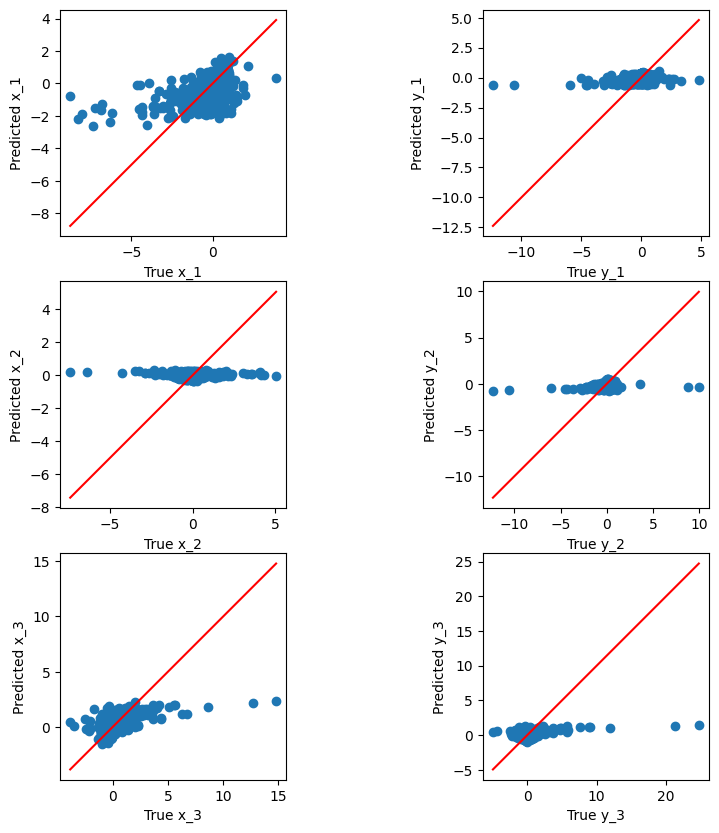

Regularizations
Ridge regression
alpha: 0.1, train: 1.3954014139799398, validation: 1.2824569283352207
alpha: 1.0, train: 1.3954014139799977, validation: 1.2824569341456202
alpha: 10.0, train: 1.3954014139863318, validation: 1.2824569922559488
alpha: 100.0, train: 1.3954014146192175, validation: 1.2824575739943913
1.2824569283352207


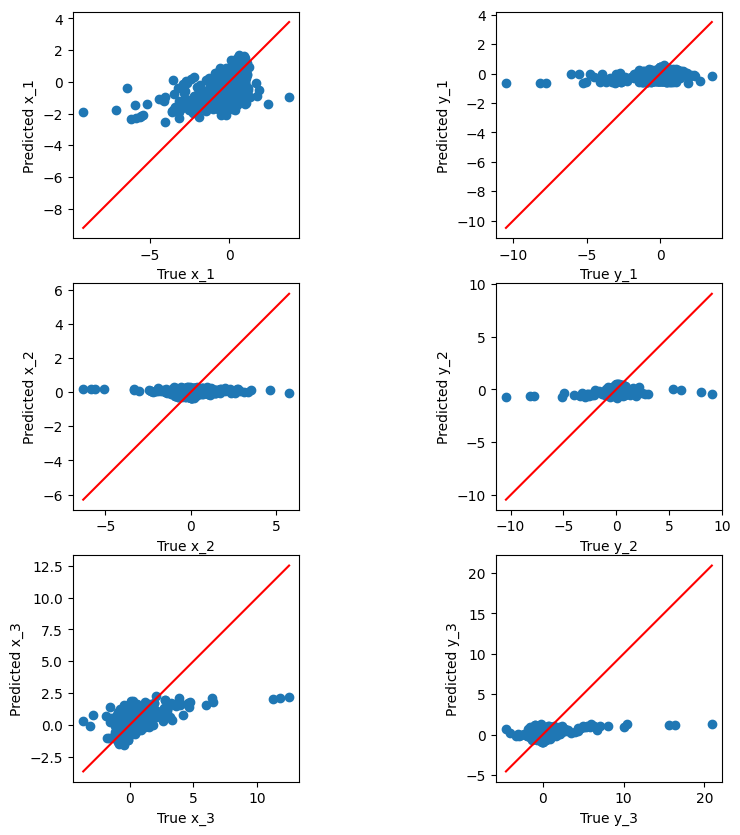

Lasso regression
alpha: 0.1, train: 1.4038605082740254, validation: 1.2987328831660443
alpha: 1.0, train: 1.4781031653387606, validation: 1.3933986969545684
alpha: 10.0, train: 1.4781031653387606, validation: 1.3933986969545684
alpha: 100.0, train: 1.4781031653387606, validation: 1.3933986969545684
1.2987328831660443


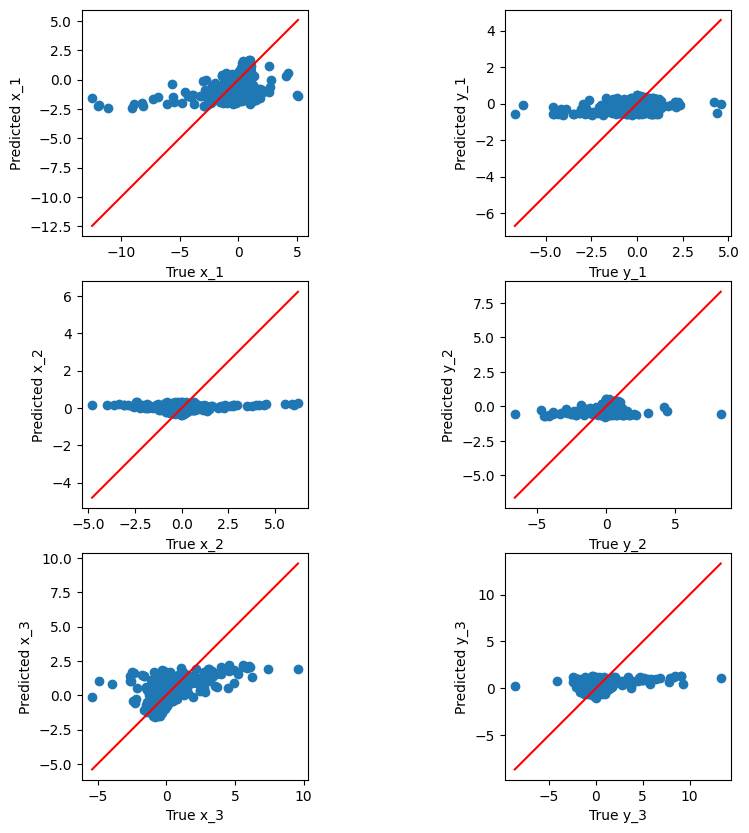

In [62]:
print("Normal linear regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()) 
])
y_pred_train, y_pred_val, linear_model = train_model(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg)
print(y_pred_val.shape)

print("train: "+str(root_mean_squared_error(y_pred_train, y_train_reg)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val_reg)))
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression")

print("Regularizations")
print("Ridge regression")
best_model_ridge, best_rmse = test_regularization(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg, regressor_type='ridge')
print(best_rmse)
best_model_ridge.predict(X_val_reg)
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression Ridge")

print("Lasso regression")
best_model_lasso, best_rmse = test_regularization(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg, regressor_type='lasso')
print(best_rmse)
best_model_lasso.predict(X_val_reg)
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression Lasso")

In [63]:
# Test the best linear regression
y_test_pred = linear_model.predict(X_test.drop(columns=info_columns+velocity_columns))
print(root_mean_squared_error(y_test_pred, y_test.drop(columns=info_columns)))

# Test with the X_test
df_X_test = pd.read_csv("../data/mlNOVA/mlNOVA/X_test.csv")
df_X_test.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'}, inplace=True)
df_X_test = df_X_test[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id']]
df_X_test[['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']] = 0
y_test_real_pred = linear_model.predict(df_X_test.drop(columns=['Id']+velocity_columns))
# Add speed columns initialized to 0
submission = pd.DataFrame({
    'Id': df_X_test['Id'],
    'x_1': y_test_real_pred[:, 0],
    'y_1': y_test_real_pred[:, 1],
    'x_2': y_test_real_pred[:, 2],
    'y_2': y_test_real_pred[:, 3],
    'x_3': y_test_real_pred[:, 4],
    'y_3': y_test_real_pred[:, 5]
})

# Save the submission file
submission.to_csv('results/baseline-model.csv', index=False)

1.4125878263282152


## Polynomial Linear Regressions

Choosing the best degree - DO NOT RUN THIS PART AGAIN, skip over

In [64]:
def evaluate_polynomial(X, y, X_val, y_val, plot_title, regressor=None, ite=20, degrees=range(1,7), sample_size=0.01):
    best_rmse_list = []
    # Store key value, degree and rmse
    best_degree_list = []
    print(degrees)
    degree_rmse_map = {}

    for _ in range(ite):
        unique_ids = X['trajectory_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * sample_size), replace=False)
        X_train_sampled = X[X['trajectory_id'].isin(sampled_ids)]
        y_train_sampled = y[y['trajectory_id'].isin(sampled_ids)]
        X_train = X_train_sampled.drop(columns=info_columns+velocity_columns)
        y_train = y_train_sampled.drop(columns=info_columns)
        
        best_model, best_rmse, best_degree, best_num_features = validate_poly_regression(X_train, y_train, X_val, y_val, regressor=regressor, degrees=degrees, verbose=False)
        best_degree_list.append(best_degree)
        best_rmse_list.append(best_rmse)
        if best_degree in degree_rmse_map:
            degree_rmse_map[best_degree]['frequency'] += 1
            degree_rmse_map[best_degree]['total_rmse'] += best_rmse
        else:
            degree_rmse_map[best_degree] = {'frequency': 1, 'total_rmse': best_rmse}
        

    # Plot Bar plot of each histogram
    # plot the Loss over Degrees
    plt.figure(figsize=(10, 6))
    unique_degrees, counts = np.unique(best_degree_list, return_counts=True)
    plt.bar(unique_degrees, counts, tick_label=unique_degrees)
    most_occuring_degree = max(degree_rmse_map, key=lambda k: degree_rmse_map[k]['frequency'])
    average_rmse = degree_rmse_map[most_occuring_degree]['total_rmse'] / degree_rmse_map[most_occuring_degree]['frequency']
    print(f"Most occurring degree: {most_occuring_degree}, Average RMSE: {average_rmse}")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(plot_title)
    plt.show()
    return average_rmse, most_occuring_degree

def plot_poly_evolution(avg_rmse_list, best_degrees_list, sample_size_list): 
    plt.figure(figsize=(12, 6))

    # Plotting the average RMSE
    plt.subplot(1, 2, 1)
    plt.plot(sample_size_list, avg_rmse_list, marker='o')
    plt.xlabel('Sample Size')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE vs Sample Size')

    # Plotting the best degrees
    plt.subplot(1, 2, 2)
    plt.plot(sample_size_list, best_degrees_list, marker='o', color='orange')
    plt.xlabel('Sample Size')
    plt.ylabel('Best Degree')
    plt.title('Best Degree vs Sample Size')

    plt.tight_layout()
    plt.show()

In [67]:
X_train_poly = X_train.drop(columns=info_columns+velocity_columns)
y_train_poly = y_train.drop(columns=info_columns)
X_val_poly = X_val.drop(columns=info_columns+velocity_columns)
y_val_poly = y_val.drop(columns=info_columns)

In [68]:
# Randomly sample 50% for validation of the data using trajectory ids
sampled_ids = np.random.choice(X_val['trajectory_id'].unique(), size=int(len(X_val['trajectory_id'].unique()) * 0.5), replace=False)
X_val_poly_sampled = X_val[X_val['trajectory_id'].isin(sampled_ids)]
y_val_poly_sampled = y_val[y_val['trajectory_id'].isin(sampled_ids)]

X_val_poly = X_val_poly_sampled.drop(columns=info_columns+velocity_columns)
y_val_poly = y_val_poly_sampled.drop(columns=info_columns)

range(1, 7)
Most occurring degree: 1, Average RMSE: 6.28946491121303


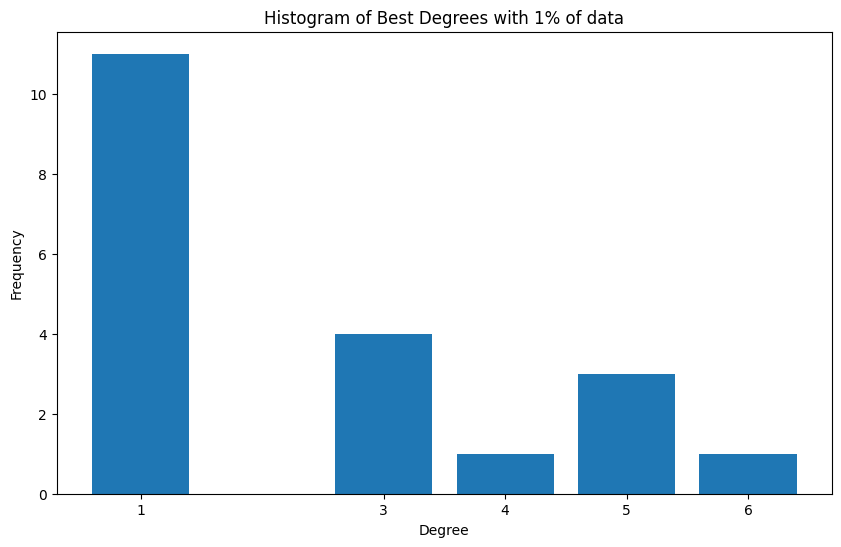

range(1, 7)
Most occurring degree: 1, Average RMSE: 3.2075998210437504


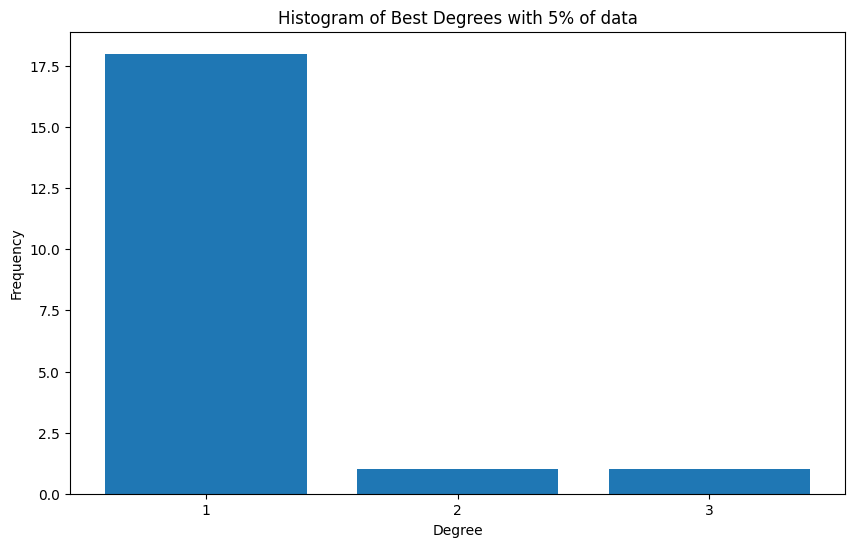

range(1, 7)
Most occurring degree: 1, Average RMSE: 2.029650373490129


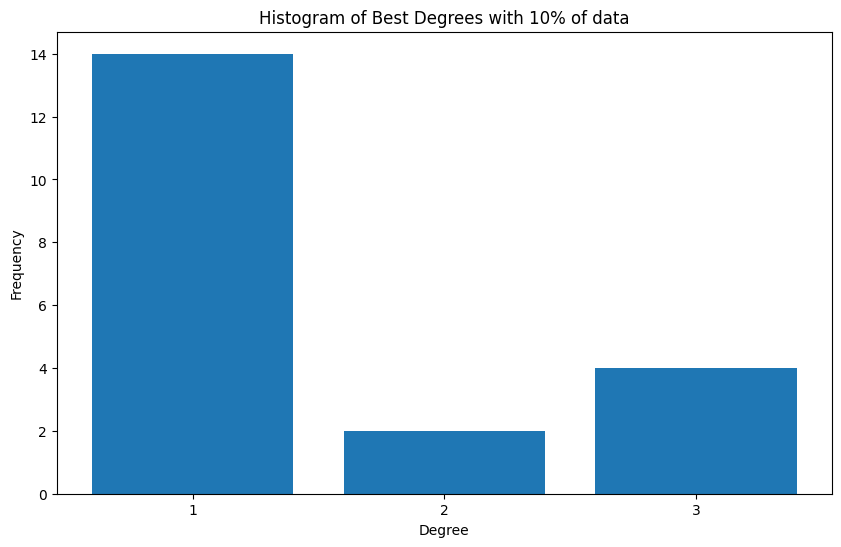

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.3658689766931036


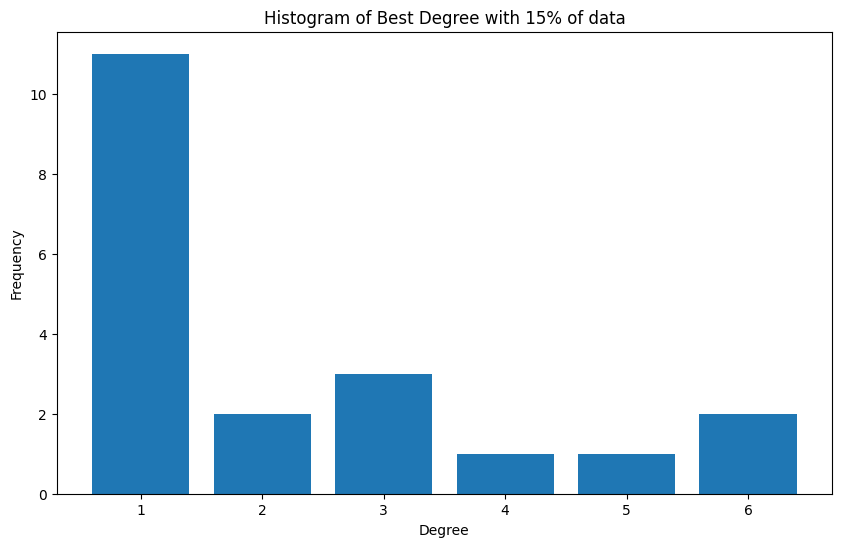

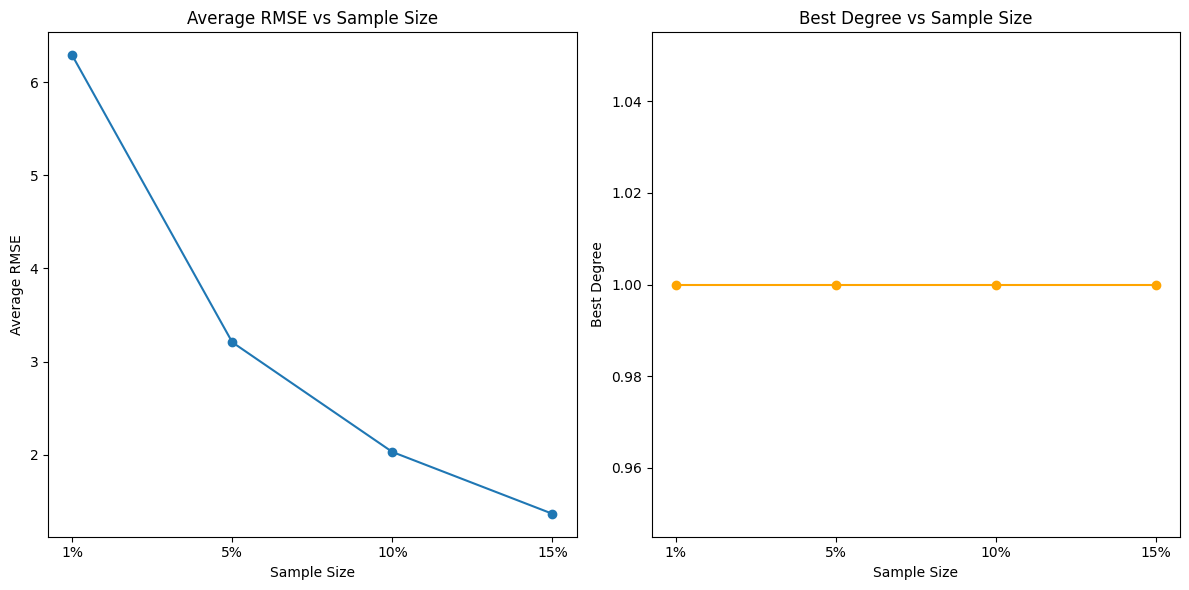

In [69]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data")
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

### Ridge Regressor

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.3384822996819439


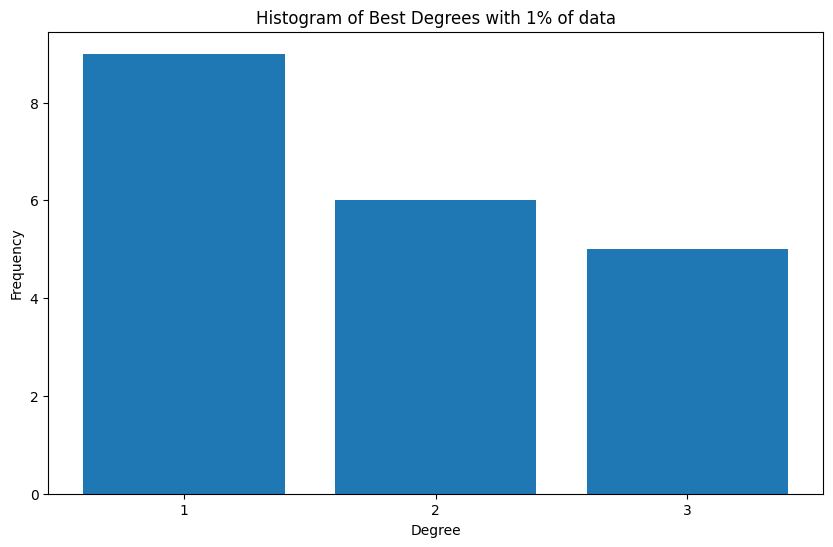

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.1442270194015383


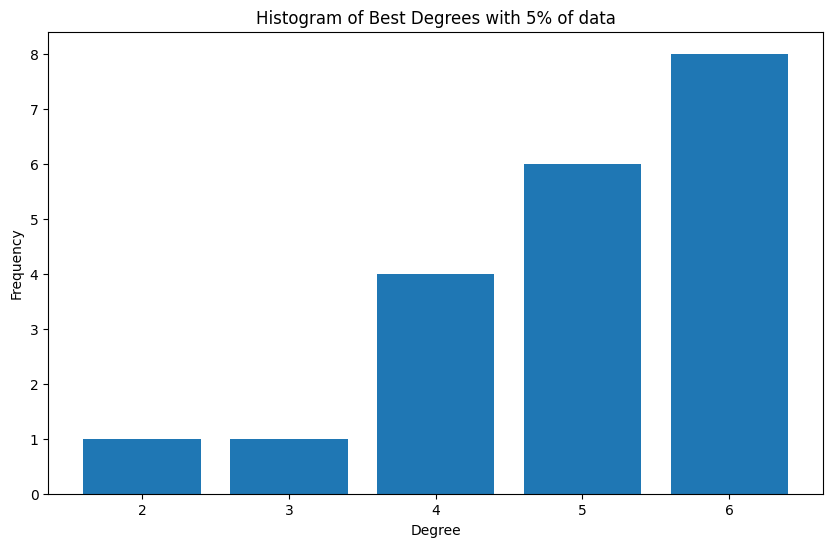

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.1127522589465444


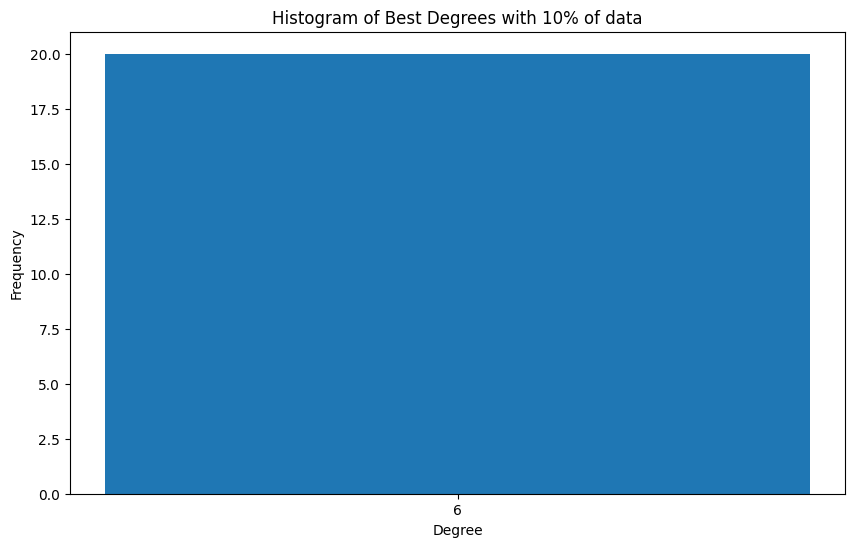

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.0776628414188612


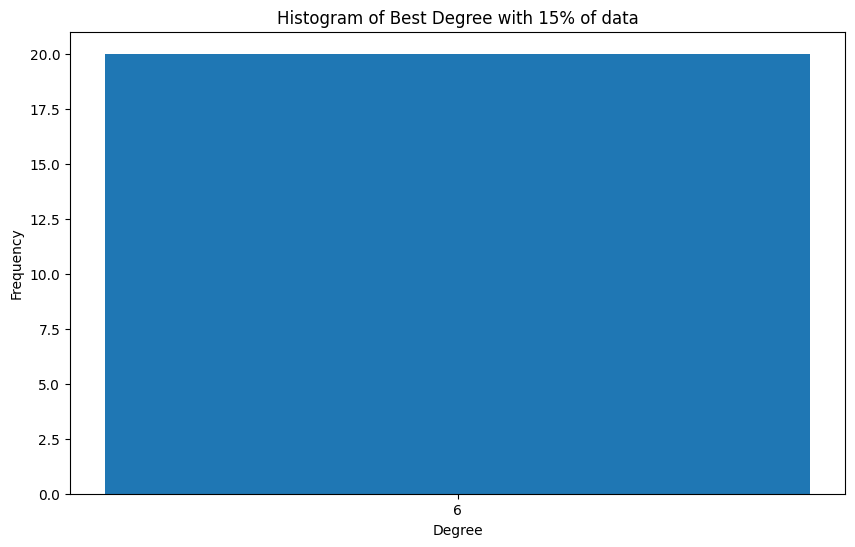

(98542, 6)


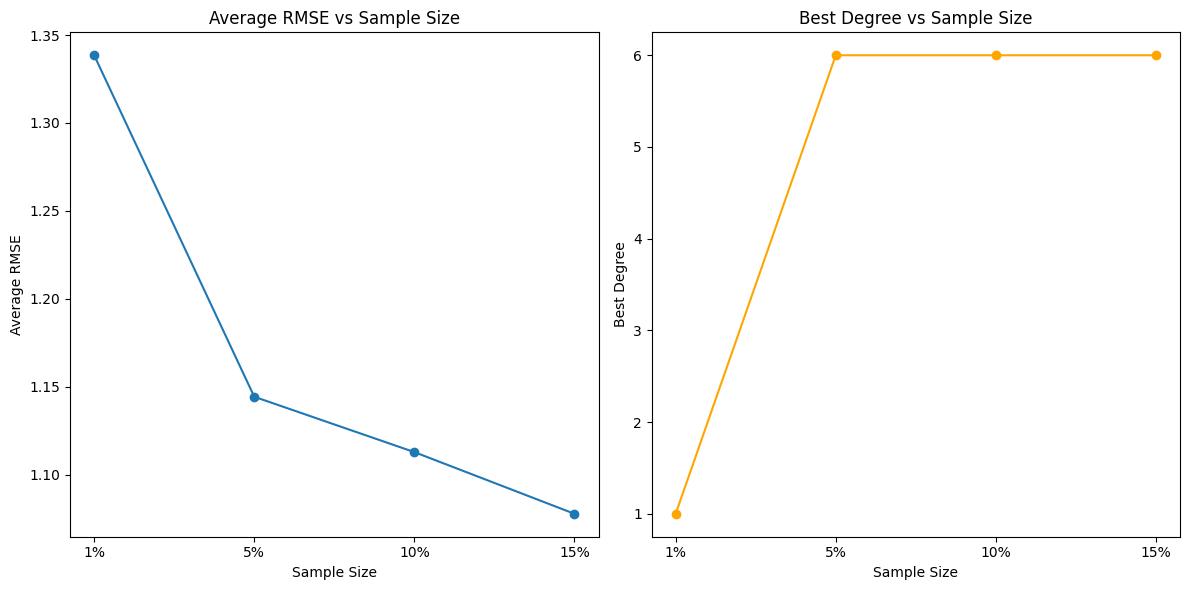

In [74]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data", regressor=Ridge())
print(y_pred_val.shape)
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", regressor=Ridge(), sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", regressor=Ridge(), sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", regressor=Ridge(), sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

### Lasso Regressor

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.3483785842456983


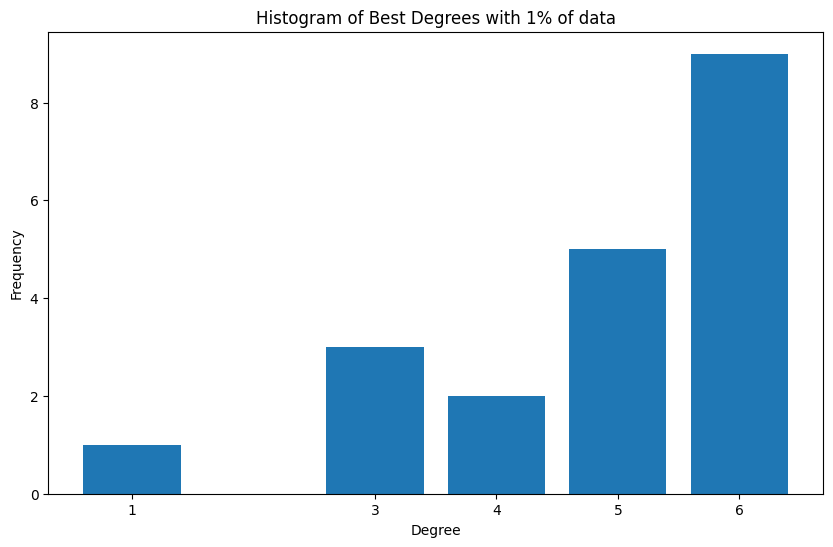

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.3462562854057791


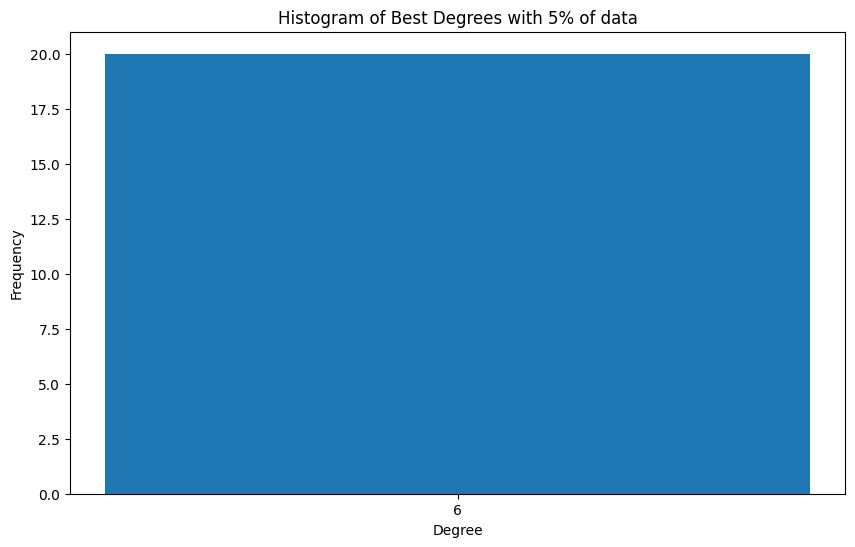

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.340354347065668


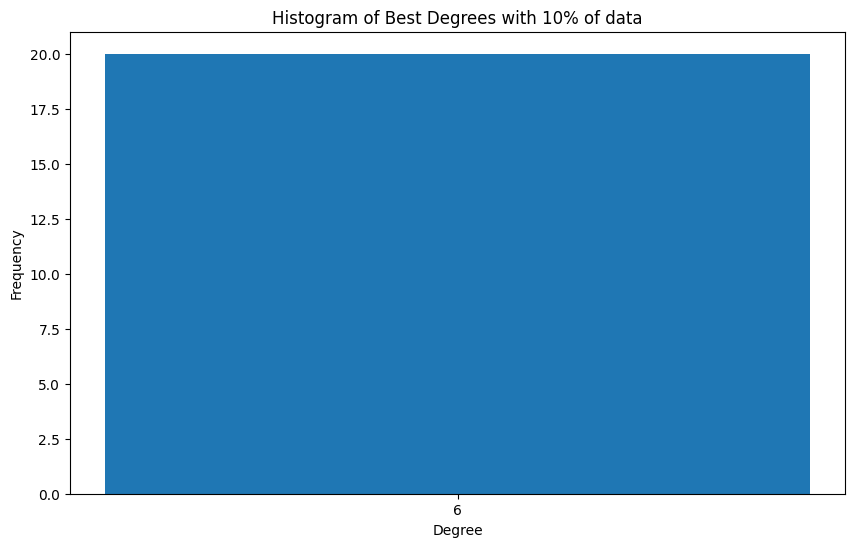

(98542, 6)
range(1, 7)
Most occurring degree: 6, Average RMSE: 1.3395666001621414


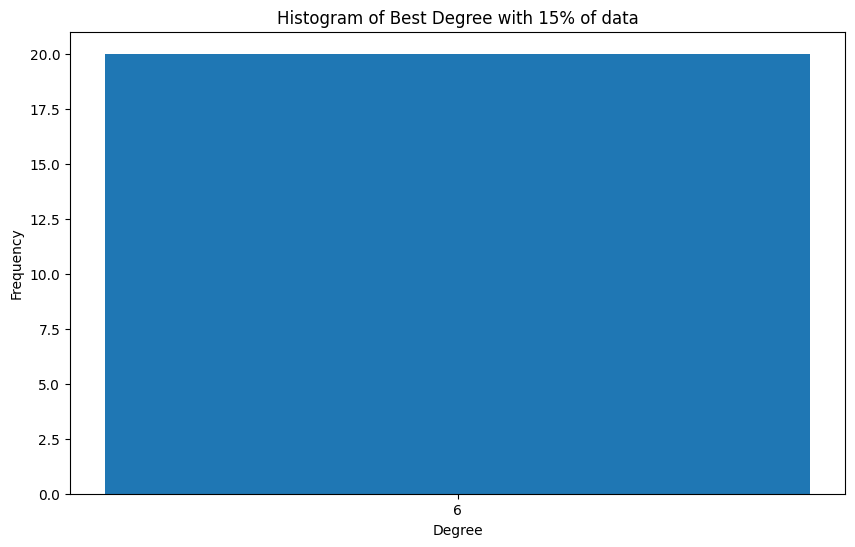

(98542, 6)


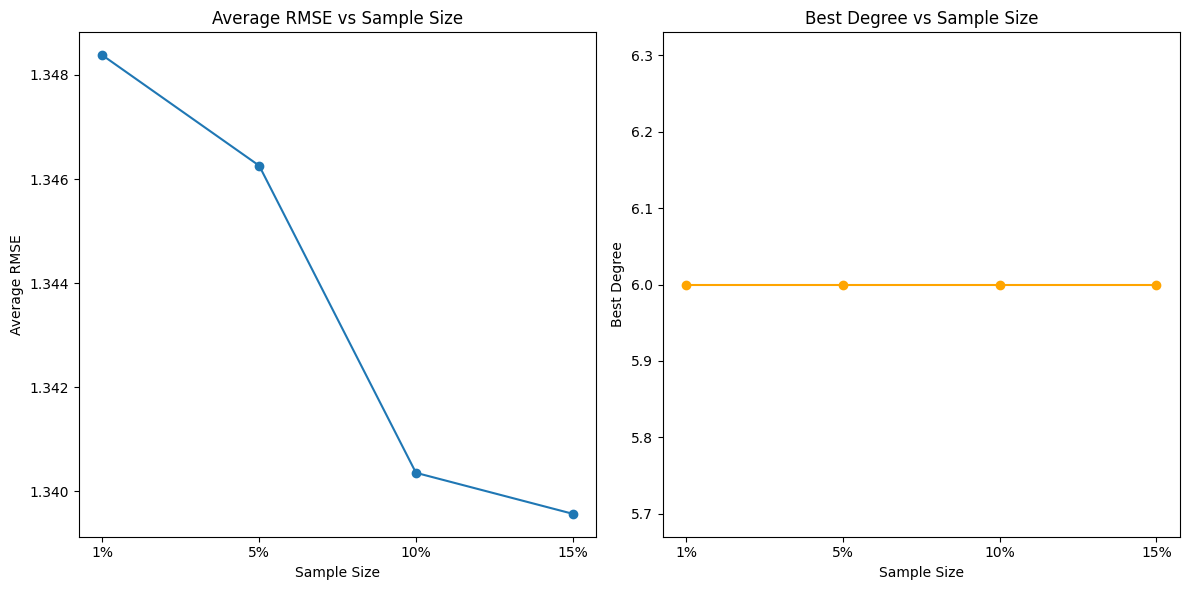

In [75]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data", regressor=Lasso())
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", regressor=Lasso(), sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", regressor=Lasso(), sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", regressor=Lasso(), sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
print(y_pred_val.shape)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

### Final model for Polynomial

In [76]:
print(y_pred_val.shape)
# Randomly sample 50% of the training data using trajectory ids
sampled_ids_train = np.random.choice(X_train['trajectory_id'].unique(), size=int(len(X_train['trajectory_id'].unique()) * 0.5), replace=False)
X_train_sampled = X_train[X_train['trajectory_id'].isin(sampled_ids_train)]
y_train_sampled = y_train[y_train['trajectory_id'].isin(sampled_ids_train)]
print(y_pred_val.shape)

# Randomly sample 50% of the validation data using trajectory ids
sampled_ids_val = np.random.choice(X_val['trajectory_id'].unique(), size=int(len(X_val['trajectory_id'].unique()) * 0.5), replace=False)
X_val_sampled = X_val[X_val['trajectory_id'].isin(sampled_ids_val)]
y_val_sampled = y_val[y_val['trajectory_id'].isin(sampled_ids_val)]
print(y_pred_val.shape)

# Fit the polynomial model using the sampled data
polynomial_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=6), Ridge())
polynomial_model.fit(X_train_sampled.drop(columns=info_columns+velocity_columns), y_train_sampled.drop(columns=info_columns))
print(y_pred_val.shape)

# Predict and evaluate
y_pred_train = polynomial_model.predict(X_train_sampled.drop(columns=info_columns+velocity_columns))
y_pred_val_poly = polynomial_model.predict(X_val_sampled.drop(columns=info_columns+velocity_columns))
print("rmse for train: "+str(root_mean_squared_error(y_pred_train, y_train_sampled.drop(columns=info_columns))))
print("rmse for validation: "+str(root_mean_squared_error(y_pred_val_poly, y_val_sampled.drop(columns=info_columns))))
print(y_pred_val.shape)

(98542, 6)
(98542, 6)
(98542, 6)
(98542, 6)
rmse for train: 1.2987524903310457
rmse for validation: 1.0994364650937174
(98542, 6)


In [88]:
# Test with the X_test
df_X_test = pd.read_csv("../data/mlNOVA/mlNOVA/X_test.csv")
df_X_test.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'}, inplace=True)
df_X_test = df_X_test[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id']]
y_test_real_pred = polynomial_model.predict(df_X_test.drop(columns=['Id']))
submission = pd.DataFrame({
    'Id': df_X_test['Id'],
    'x_1': y_test_real_pred[:, 0],
    'y_1': y_test_real_pred[:, 1],
    'x_2': y_test_real_pred[:, 2],
    'y_2': y_test_real_pred[:, 3],
    'x_3': y_test_real_pred[:, 4],
    'y_3': y_test_real_pred[:, 5]
})

# Save the submission file
submission.to_csv('results/polynomial_submission.csv', index=False)

## Feature Engineering

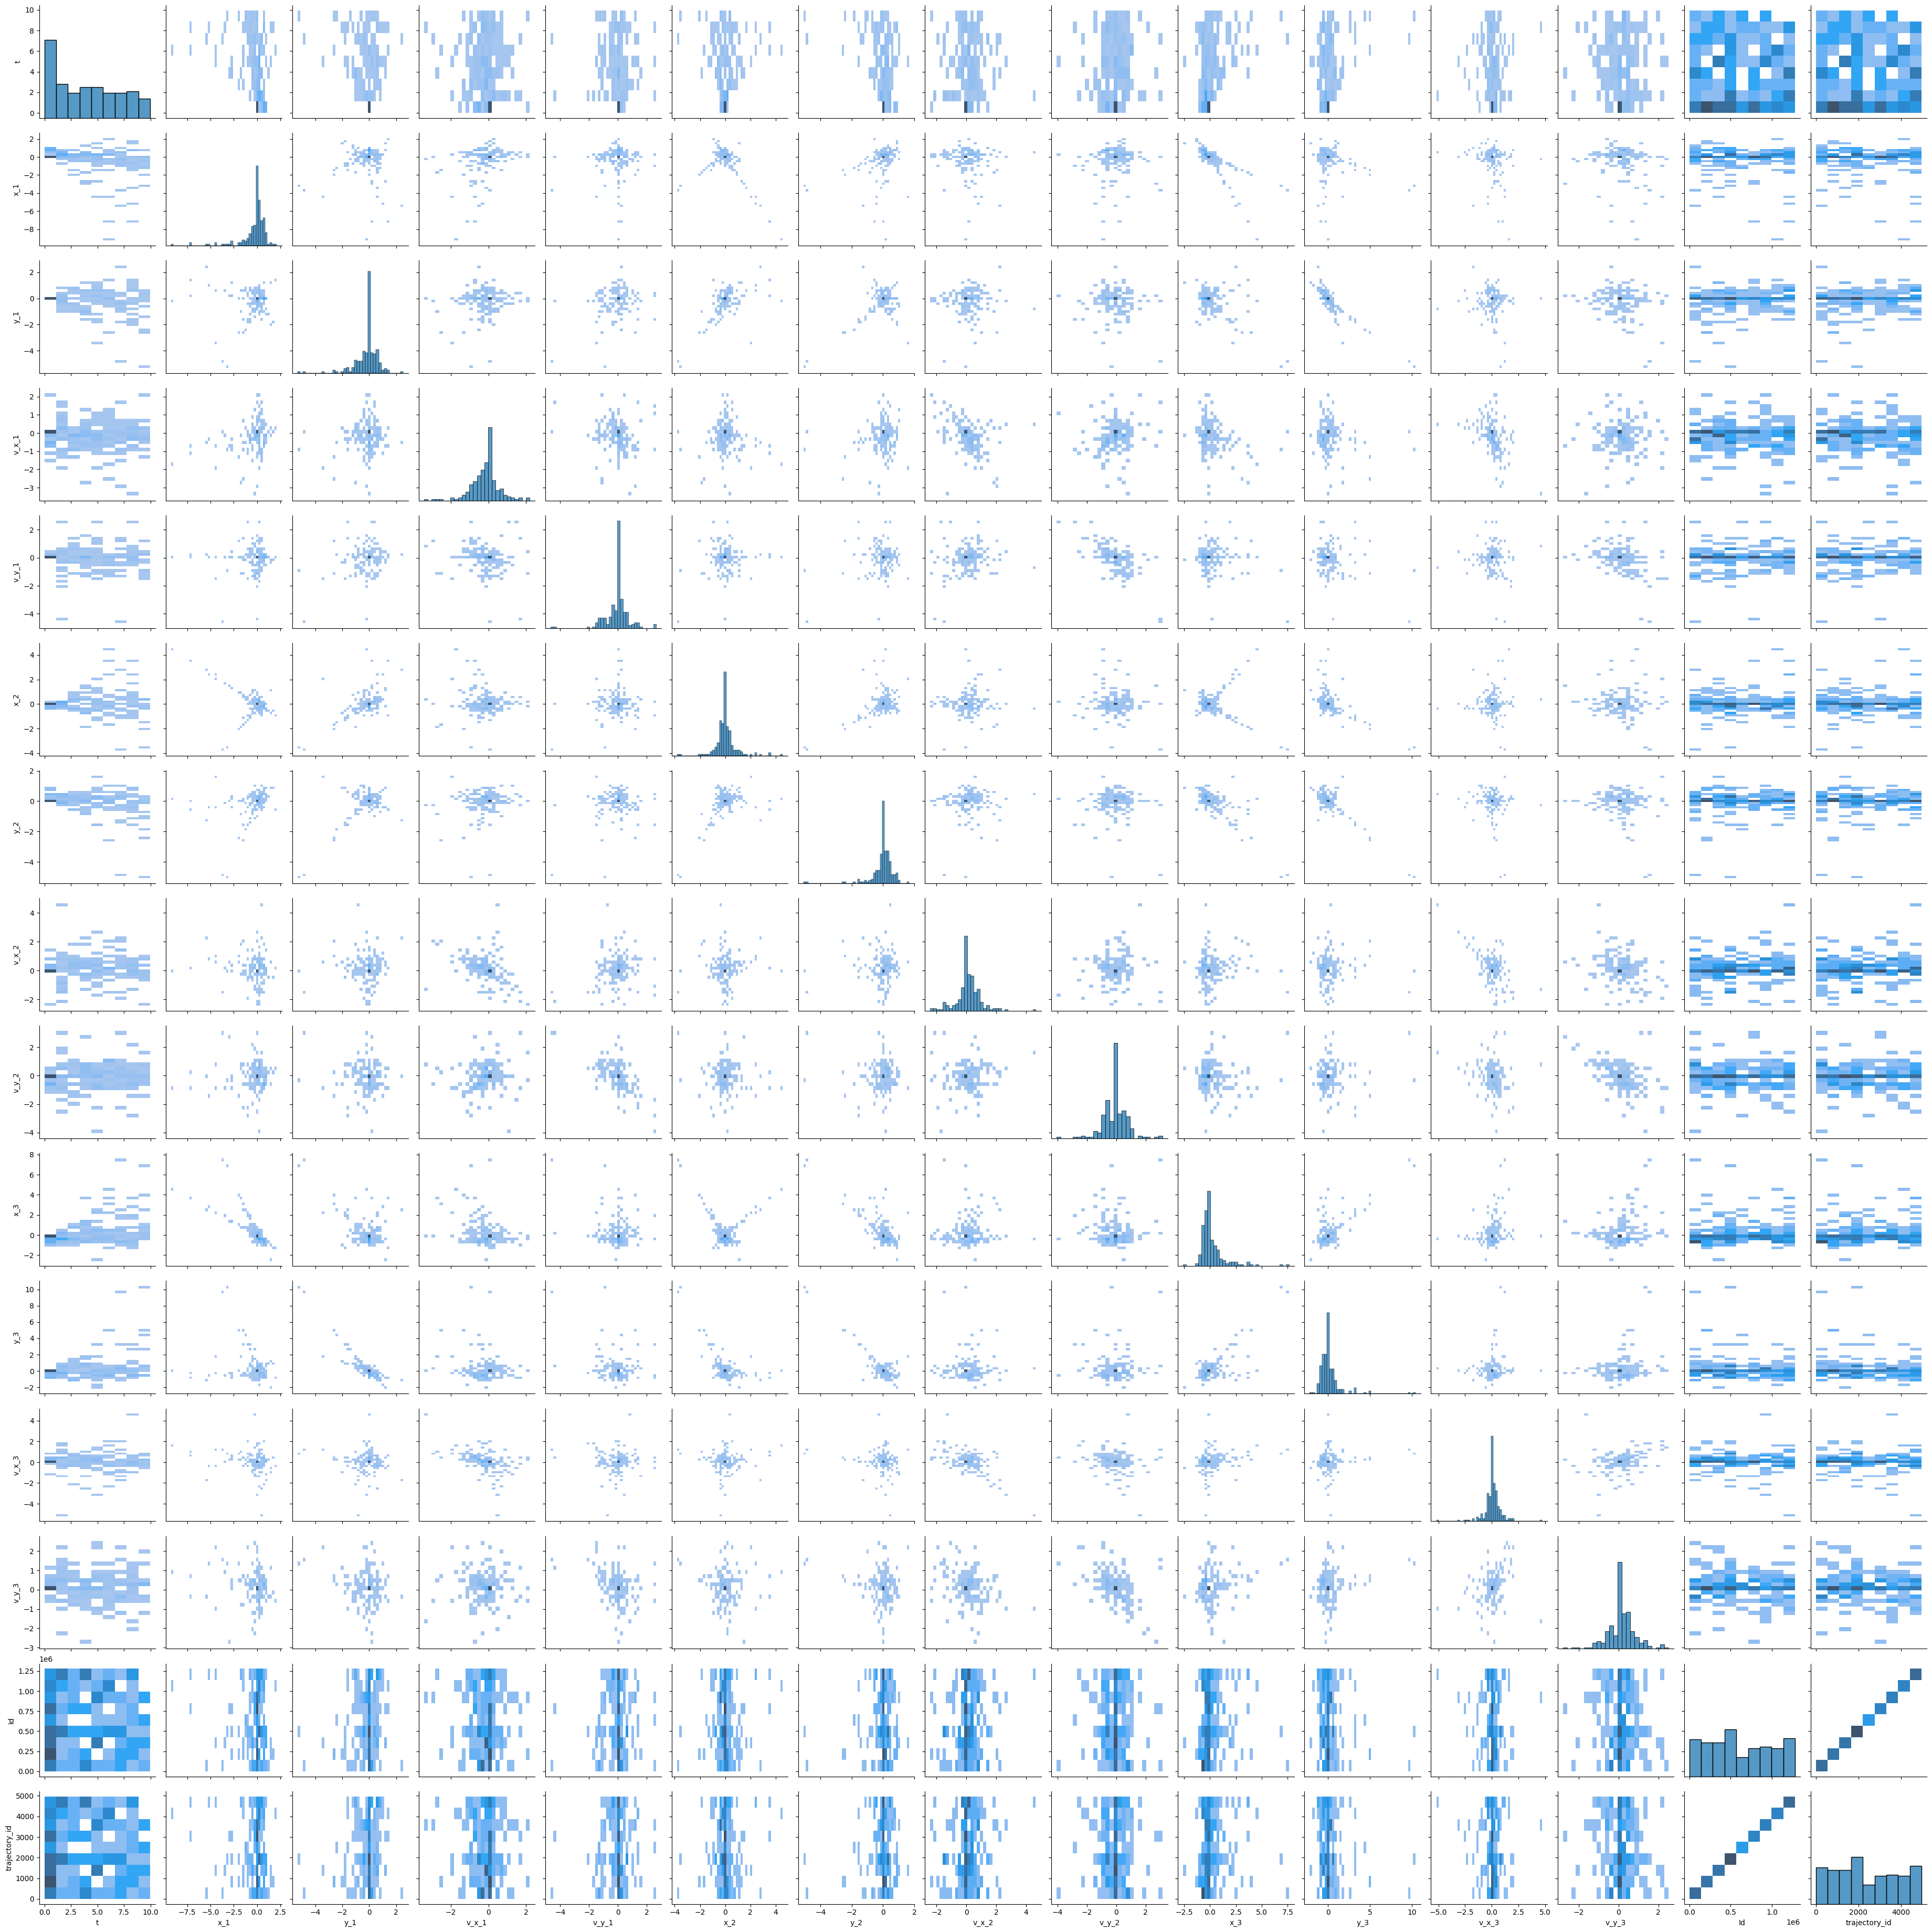

In [96]:
sns.pairplot(df.sample(200), kind="hist")

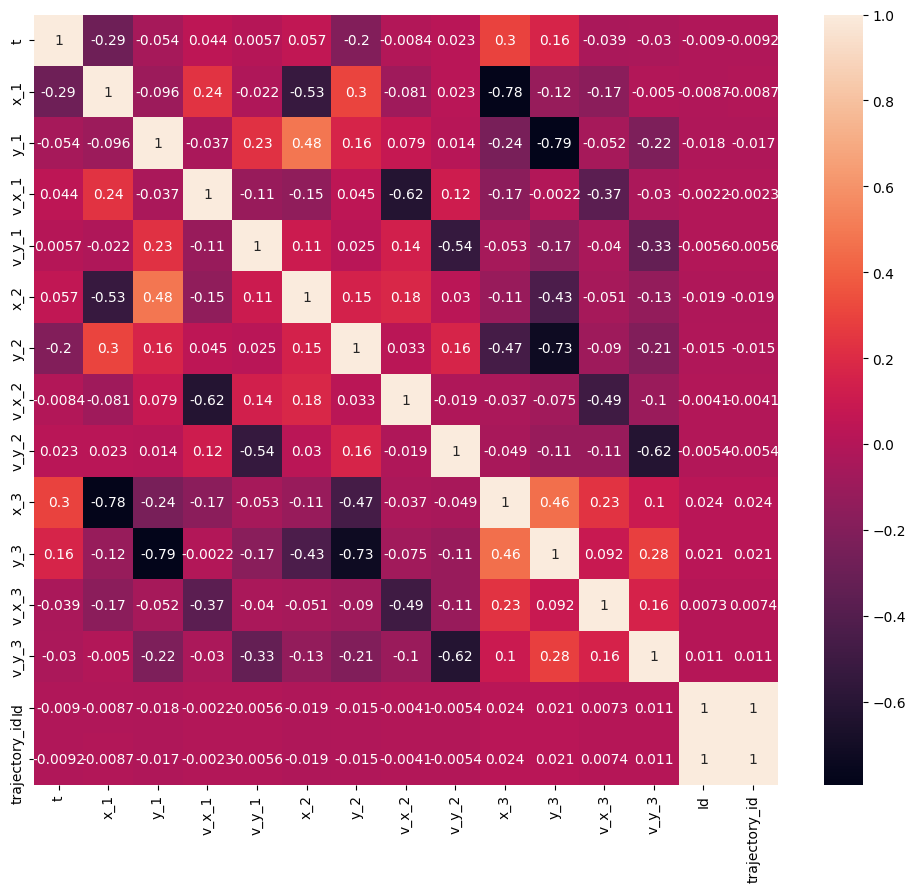

In [97]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

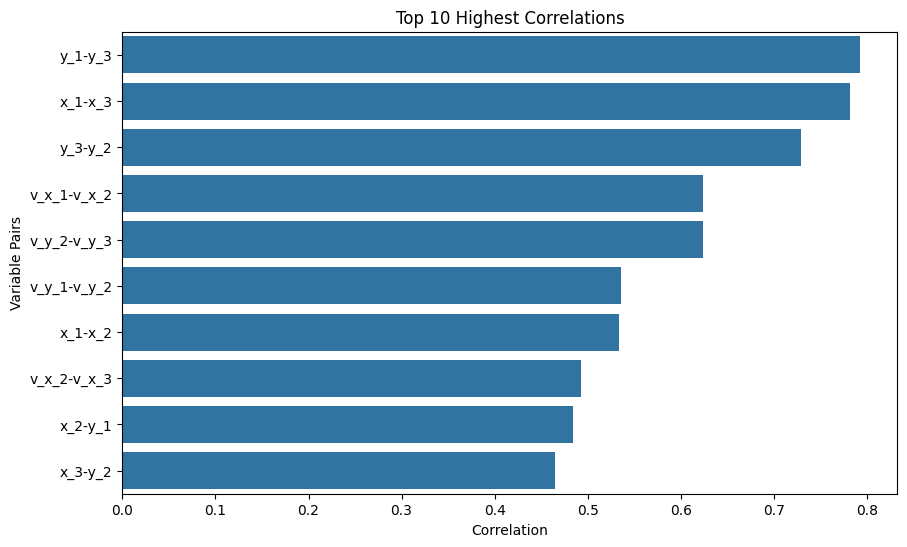

In [98]:
# Sort the interactions by the absolute value of the correlations
sorted_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()

# Ensure the labels exist before dropping them
labels_to_drop = [('t', 't'), ('trajectory_id', 'Id'), ('Id', 'trajectory_id'), ('t', 'trajectory_id'), ('trajectory_id', 't'), ('t', 'Id'), ('Id', 't'), ('trajectory_id', 'trajectory_id')]
existing_labels_to_drop = [label for label in labels_to_drop if label in sorted_corr.index]
sorted_corr = sorted_corr.drop(labels=existing_labels_to_drop)

# Plot the highest 10 correlations
top_10_corr = sorted_corr.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=[f"{x[0]}-{x[1]}" for x in top_10_corr.index])
plt.xlabel('Correlation')
plt.ylabel('Variable Pairs')
plt.title('Top 10 Highest Correlations')
plt.show()

In [92]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_reg_FE = X_train.drop(columns=info_columns)
y_train_reg_FE = y_train.drop(columns=info_columns)
X_val_reg_FE = X_val.drop(columns=info_columns)
y_val_reg_FE = y_val.drop(columns=info_columns)

# TASK 3.3 and 3.4

## Nonparametric Model - the k-Nearest Neighbors Regressor

In [79]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_non_parametric = X_train.drop(columns=info_columns+velocity_columns)
y_train_non_parametric = y_train.drop(columns=info_columns)
X_val_non_parametric = X_val.drop(columns=info_columns+velocity_columns)
y_val_non_parametric = y_val.drop(columns=info_columns)

k: 1, RMSE: 1.014650115557888, Training time: 0.41436076164245605, Inference time: 0.22268104553222656
k: 2, RMSE: 0.8822536797006731, Training time: 0.4184541702270508, Inference time: 0.2617979049682617
k: 3, RMSE: 0.8342167504610293, Training time: 0.4753842353820801, Inference time: 0.2755608558654785
k: 4, RMSE: 0.8228274152287579, Training time: 0.38211989402770996, Inference time: 0.295367956161499
k: 5, RMSE: 0.799930421867898, Training time: 0.4284391403198242, Inference time: 0.3178718090057373
k: 6, RMSE: 0.7991098028276837, Training time: 0.38249802589416504, Inference time: 0.34218788146972656
k: 7, RMSE: 0.8011560355607739, Training time: 0.38196396827697754, Inference time: 0.3606140613555908
k: 8, RMSE: 0.8043349423384911, Training time: 0.3952350616455078, Inference time: 0.38400912284851074
k: 9, RMSE: 0.8085434195103602, Training time: 0.4603891372680664, Inference time: 0.39792704582214355
k: 10, RMSE: 0.8080918698874768, Training time: 0.38256406784057617, Inferenc

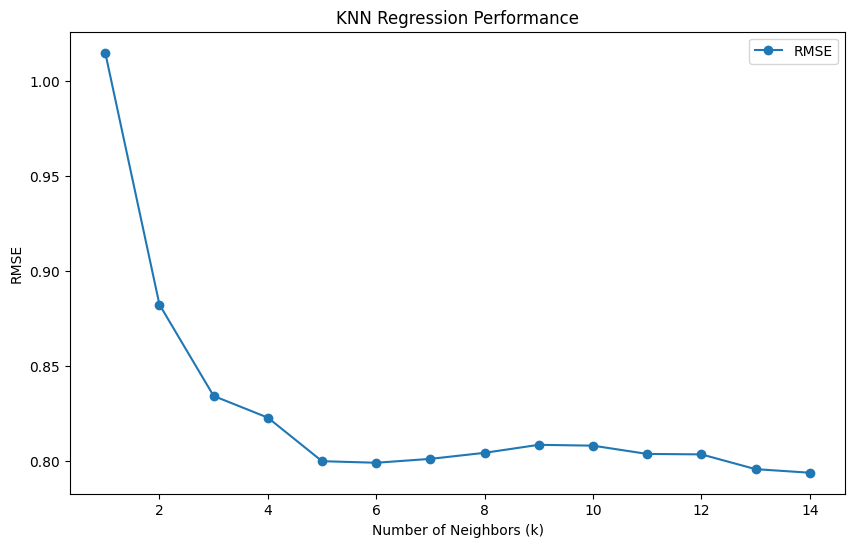

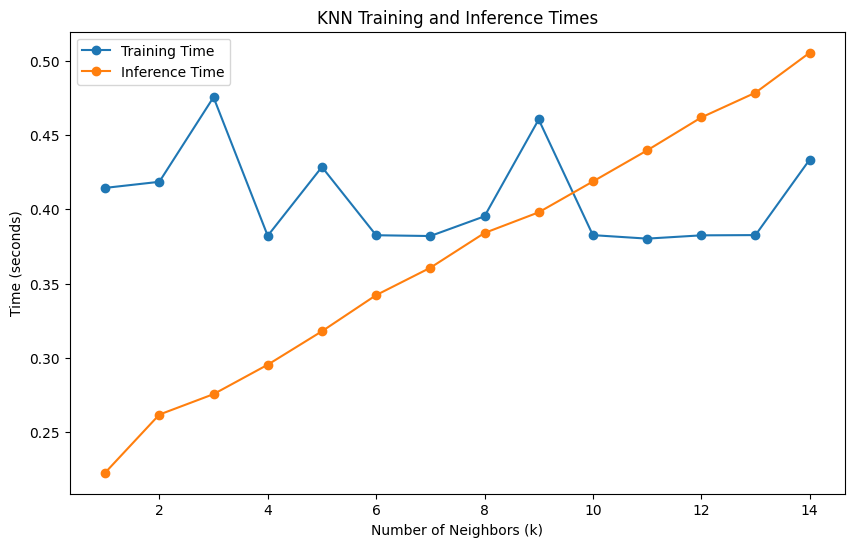

In [82]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import time

import matplotlib.pyplot as plt

def validate_knn_regression(X_train, y_train, X_val, y_val, k_range=range(1, 15)):
    rmses = []
    training_times = []
    inference_times = []

    for k in k_range:
        start_time = time.time()
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        training_time = time.time() - start_time

        start_time = time.time()
        y_pred = knn.predict(X_val)
        inference_time = time.time() - start_time

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
        training_times.append(training_time)
        inference_times.append(inference_time)

        print(f"k: {k}, RMSE: {rmse}, Training time: {training_time}, Inference time: {inference_time}")

    best_k = k_range[np.argmin(rmses)]
    best_rmse = min(rmses)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, rmses, marker='o', label='RMSE')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.title('KNN Regression Performance')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, training_times, marker='o', label='Training Time')
    plt.plot(k_range, inference_times, marker='o', label='Inference Time')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Time (seconds)')
    plt.title('KNN Training and Inference Times')
    plt.legend()
    plt.show()

    return best_k, best_rmse, training_times, inference_times, rmses

# Example usage:
best_k, best_rmse, training_times, inference_times, rmses = validate_knn_regression(X_train_non_parametric, y_train_non_parametric, X_val_non_parametric, y_val_non_parametric)

In [ ]:
# Test with the X_test
df_X_test = pd.read_csv("../data/mlNOVA/mlNOVA/X_test.csv")
df_X_test.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'}, inplace=True)
df_X_test = df_X_test[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id']]

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_non_parametric, y_train_non_parametric)
y_test_real_pred = knn.predict(df_X_test.drop(columns=['Id']))

submission = pd.DataFrame({
    'Id': df_X_test['Id'],
    'x_1': y_test_real_pred[:, 0],
    'y_1': y_test_real_pred[:, 1],
    'x_2': y_test_real_pred[:, 2],
    'y_2': y_test_real_pred[:, 3],
    'x_3': y_test_real_pred[:, 4],
    'y_3': y_test_real_pred[:, 5]
})

# Save the submission file
submission.to_csv('results/knn_submission.csv', index=False)